In [18]:
#pip install cartiflette

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from cartiflette import carti_download


In [64]:
from sklearn.cluster import DBSCAN
import numpy as np

In [63]:
bibliotheque_guadeloupe = pd.read_csv("../data/processed/cartographie/bibliotheque_guadeloupe.csv")
bibliotheque_reunion = pd.read_csv("../data/processed/cartographie/bibliotheque_reunion.csv")
bibliotheque_centre_val_de_loire = pd.read_csv("../data/processed/cartographie/bibliotheque_centre_val_de_loire.csv")

librairie_guadeloupe = pd.read_csv("../data/processed/cartographie/librairie_guadeloupe.csv")
librairie_reunion = pd.read_csv("../data/processed/cartographie/librairie_reunion.csv")
librairie_centre_val_de_loire = pd.read_csv("../data/processed/cartographie/librairie_centre_val_de_loire.csv")

### Nettoyage des coordonnées aberrantes

In [21]:
def clean_points(df):
    df = df[(df.latitude >= -90) & (df.latitude <= 90)]
    df = df[(df.longitude >= -180) & (df.longitude <= 180)]
    return df

bibliotheque_guadeloupe = clean_points(bibliotheque_guadeloupe)
librairie_guadeloupe = clean_points(librairie_guadeloupe)
bibliotheque_reunion = clean_points(bibliotheque_reunion)
librairie_reunion = clean_points(librairie_reunion)
bibliotheque_centre_val_de_loire = clean_points(bibliotheque_centre_val_de_loire)
librairie_centre_val_de_loire = clean_points(librairie_centre_val_de_loire)


### Conversion en GeoDataFrame

In [22]:
def df_to_gdf(df):
    return gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:4326"
    )

bibliotheque_guadeloupe = df_to_gdf(bibliotheque_guadeloupe)
librairie_guadeloupe = df_to_gdf(librairie_guadeloupe)
bibliotheque_reunion = df_to_gdf(bibliotheque_reunion)
librairie_reunion = df_to_gdf(librairie_reunion)
bibliotheque_centre_val_de_loire = df_to_gdf(bibliotheque_centre_val_de_loire)
librairie_centre_val_de_loire = df_to_gdf(librairie_centre_val_de_loire)


### Récupération des contours des départements

In [23]:
departements = carti_download(
    values="France",
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)


### Filtrer les régions

In [24]:
# DROM
def filter_region_drom(gdf_depts, region_name):
    return gdf_depts[gdf_depts['LIBELLE_DEPARTEMENT'].str.contains(region_name, case=False)]

# Centre-Val de Loire : liste de codes INSEE
centre_val_de_loire_depts = ["18","28","36","37","41","45"]

regions = {
    "Guadeloupe": filter_region_drom(departements, "Guadeloupe"),
    "Réunion": filter_region_drom(departements, "Réunion"),
    "Centre-Val de Loire": departements[departements["INSEE_DEP"].isin(centre_val_de_loire_depts)]
}


### Filtrer les points réellement dans la région

In [25]:
def points_in_region(points_gdf, region_gdf, buffer_deg=0.05):
    if region_gdf.empty:
        return gpd.GeoDataFrame(columns=points_gdf.columns, crs=points_gdf.crs)
    
    region_polygon = region_gdf.geometry.union_all().buffer(buffer_deg)
    filtered = points_gdf[points_gdf.geometry.within(region_polygon)]
    return filtered

bibliotheque_guadeloupe = points_in_region(bibliotheque_guadeloupe, regions["Guadeloupe"])
librairie_guadeloupe = points_in_region(librairie_guadeloupe, regions["Guadeloupe"])
bibliotheque_reunion = points_in_region(bibliotheque_reunion, regions["Réunion"])
librairie_reunion = points_in_region(librairie_reunion, regions["Réunion"])
bibliotheque_centre_val_de_loire = points_in_region(bibliotheque_centre_val_de_loire, regions["Centre-Val de Loire"])
librairie_centre_val_de_loire = points_in_region(librairie_centre_val_de_loire, regions["Centre-Val de Loire"])


### Calcul indicateurs

In [26]:
population_fixee = {
    "Guadeloupe": 384_315,
    "Réunion": 896_200,
    "Centre-Val de Loire": 2_560_000
}

def indicators(region_name, region_gdf, biblio_gdf):
    # Population : utiliser la colonne si elle existe sinon valeur fixée
    
    population = population_fixee.get(region_name, 1)
    
    # Superficie en km²
    if 'SURFACE' in region_gdf.columns:
        superficie = region_gdf['SURFACE'].sum()
    else:
        # Conversion en projection métrique pour calcul précis
        region_proj = region_gdf.to_crs(epsg=2154)
        superficie = region_proj.geometry.area.sum() / 1e6  # m² -> km²
    
    nb_biblio = len(biblio_gdf)
    biblio_par_hab = nb_biblio / population *100000 if population > 0 else 0
    biblio_par_km2 = nb_biblio / superficie *100 if superficie > 0 else 0
    
    return nb_biblio, biblio_par_hab, biblio_par_km2


### carte 

In [54]:
def plot_region(region_name, region_gdf, biblio_gdf, librairie_gdf,flag_legend):
    if region_gdf.empty:
        print(f"Aucun contour trouvé pour {region_name}.")
        return
    if biblio_gdf.empty and librairie_gdf.empty:
        print(f"Aucun point à afficher pour {region_name}.")
        return

    nb_biblio, biblio_par_hab, biblio_par_km2 = indicators(region_name, region_gdf, biblio_gdf)

    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Contours
    region_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=1.5)
    
    # Points
    if not biblio_gdf.empty:
        biblio_gdf.plot(ax=ax, color='blue', markersize=40, label='Bibliothèque', alpha=0.7)
    if not librairie_gdf.empty:
        librairie_gdf.plot(ax=ax, color='red', markersize=40, label='Librairie', alpha=0.7)
    
    # Centrer
    minx, miny, maxx, maxy = region_gdf.total_bounds
    dx = (maxx - minx) * 0.1
    dy = (maxy - miny) * 0.1
    ax.set_xlim(minx - dx, maxx + dx)
    ax.set_ylim(miny - dy, maxy + dy)
    
    # Afficher indicateurs à droite
    info_text = (
        f"Région : {region_name}\n"
        f"Nb bibliothèques : {nb_biblio}\n"
        f"Bibliothèques / 100 000 hab : {biblio_par_hab:.4f}\n"
        f"Bibliothèques / 100 km² : {biblio_par_km2:.4f}"
    )
    
    print(info_text)
    
    ax.set_axis_off()
    if(flag_legend):
        ax.legend()
    plt.show()
    return fig



# Cartes

Région : Guadeloupe
Nb bibliothèques : 43
Bibliothèques / 100 000 hab : 11.1887
Bibliothèques / 100 km² : 2.0529


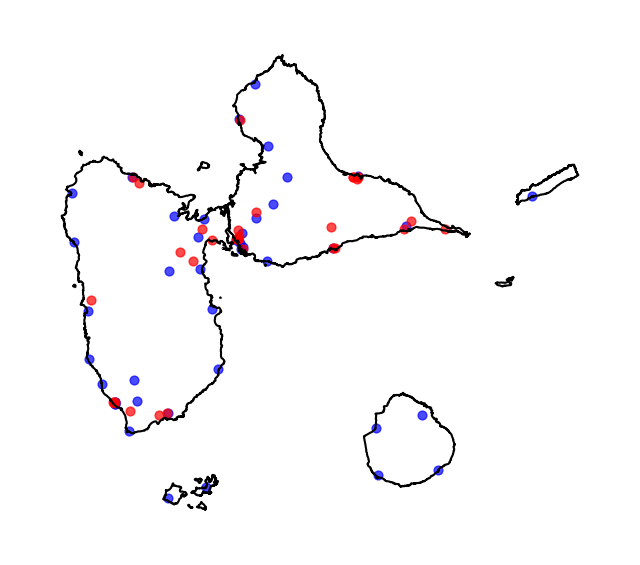

In [55]:
carte_guadeloupe = plot_region("Guadeloupe", regions["Guadeloupe"], bibliotheque_guadeloupe, librairie_guadeloupe,False)


Région : Réunion
Nb bibliothèques : 79
Bibliothèques / 100 000 hab : 8.8150
Bibliothèques / 100 km² : 0.8916


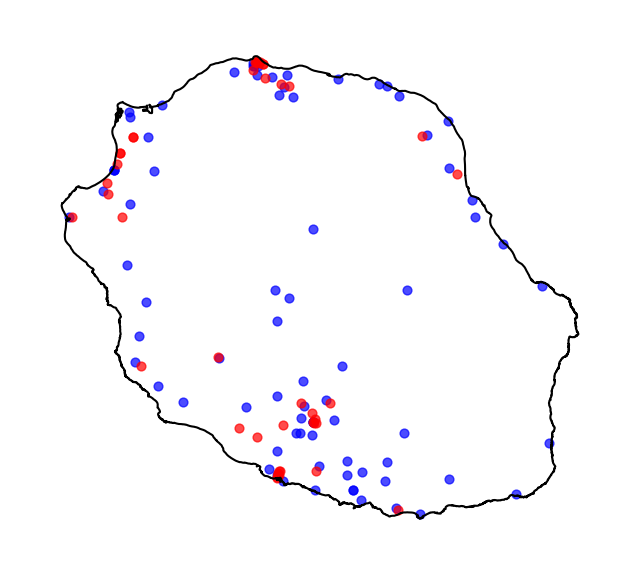

In [56]:
carte_reunion = plot_region("Réunion", regions["Réunion"], bibliotheque_reunion, librairie_reunion,False)

Région : Centre-Val de Loire
Nb bibliothèques : 852
Bibliothèques / 100 000 hab : 33.2812
Bibliothèques / 100 km² : 2.1586


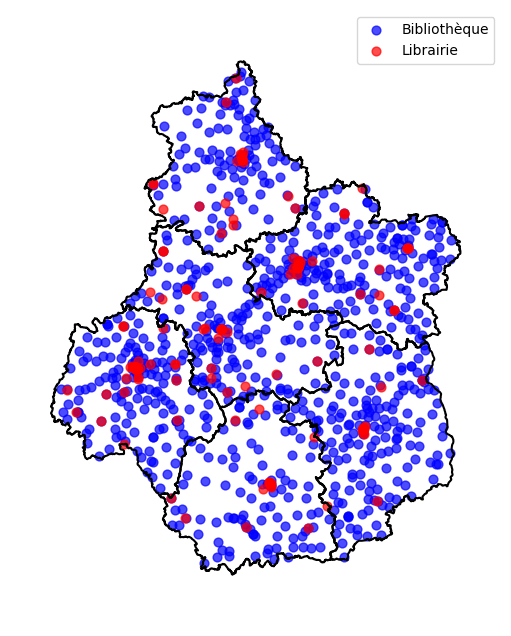

In [58]:
carte_cvl = plot_region("Centre-Val de Loire", regions["Centre-Val de Loire"], bibliotheque_centre_val_de_loire, librairie_centre_val_de_loire,True)

# Exportation 

Nous choisissons d'enregistrer les images au format svg car cela permet d'étirer les images après sur les posters en gardant les proportions.

In [59]:
carte_guadeloupe.savefig("../outputs/cartes/carte_librairie_bibliotheque_guadeloupe.svg", format="svg", dpi=300, bbox_inches="tight")

In [60]:
carte_reunion.savefig("../outputs/cartes/carte_librairie_bibliotheque_reunion.svg", format="svg", dpi=300, bbox_inches="tight")

In [61]:
carte_cvl.savefig("../outputs/cartes/carte_librairie_bibliotheque_cvl.svg", format="svg", dpi=300, bbox_inches="tight")